# Formalia:

Please read the [assignment overview page](https://github.com/SocialComplexityLab/socialgraphs2024/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday November 5th, 2024 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via DTU Learn

In the exercises below, I describe the exercises in a general way. Drawing in the right parts of the exercises is part of the assignment. (That way we're helping you get a little bit more ready for the Final Project, where you have to decide what information to include in your report and analysis). 


# Part 1: Genres and communities and plotting 

The questions below are based on Lecture 7, part 2.

* Write about genres and modularity.
* Detect the communities, discuss the value of modularity in comparison to the genres.
* Calculate the matrix $D$ and discuss your findings.
* Plot the communities and comment on your results.

# Part 2: TF-IDF to understand genres and communities 

The questions below  are based on Lecture 7, part 2 and 3.

* Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.
* Calculate and visualize TF-IDF for the genres and communities.
* Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.

# Part 3: Sentiment of the artists and communities

The questions below are based on Lecture 8

* Calculate the sentiment of the Artists pages (OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
* Discuss the sentiment of the largest communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?

## 1.1 Genres and Modularity

Modularity measures whether groups of nodes in a network are more connected to each other than to the rest of the network. Networks with high modularity are those where nodes can be split into clusters or communities that are tightly connected within themselves than to the rest of the nodes. 

One would expect the communities detected in this particular network to correspond with the genres the musicians in question specialize in. 

## 1.2 Detect the Communities, discuss the value of modularity in comparision to the genres
A modularity detection function is defined, based on the textbook and for the special case where community detection is not automatic but assigned in the form a genres.

In [2]:
# Open the networks from the gexf files
import networkx as nx
import json

# Read the first gexf graph
subgraph = nx.read_gexf("subgraph.gexf")

# Read the second gexf graph
undirected = nx.read_gexf("undirected.gexf")

def modularity(network):
    # Modularity score , M
    modularity = 0
    # Number of edges in the network, L
    num_edges = network.number_of_edges()
    # Number of unique genres in the network, n_c
    num_genres = len(set([network.nodes[node]['genre'] for node in network.nodes]))

    # split the network into subgraphs based on genre
    subgraphs = {}
    for node in network.nodes:
        genre = network.nodes[node]['genre']
        if genre not in subgraphs:
            subgraphs[genre] = nx.Graph()
        subgraphs[genre].add_node(node)
    
    for edge in network.edges:
        node1 = edge[0]
        node2 = edge[1]
        genre1 = network.nodes[node1]['genre']
        genre2 = network.nodes[node2]['genre']
        if genre1 == genre2:
            subgraphs[genre1].add_edge(node1, node2)
    
    # Calculate the modularity score

    # Number of edges between nodes of the same genre, L_c
    num_edges_same_genre = {genre: subgraph.number_of_edges() for genre, subgraph in subgraphs.items()}

    # Total degree of nodes of the same genre, k_c
    total_degree_same_genre = {genre: sum(dict(subgraph.degree()).values()) for genre, subgraph in subgraphs.items()}

    # Calculate the modularity score
    for genre in subgraphs:
        modularity += num_edges_same_genre[genre] / num_edges - (total_degree_same_genre[genre] / (2 * num_edges)) ** 2

    
    return modularity
                                                                                                                                                                                                                       

The genre is added as an attribute to the nodes.

In [3]:
# Retrieve the genres
file_path = 'genres.txt'
with open(file_path, 'r') as file:
    content = file.read()
data = json.loads(content)

In the first case, we assign the first genre in the list of genres to the corresponding node, and 'Unknown' for nodes whose genre cannot be found. ( 0th index )

In [4]:
# Assign the genres to the nodes
# Iterate over the nodes in the network
undirected = nx.read_gexf("undirected.gexf")
for node in undirected.nodes:
    # Get the name of the node
    node_name = undirected.nodes[node]['label']
    # Check if the name exists in the JSON data
    if node_name in data:
        # Add the genre attribute to the node with the corresponding values from the JSON data
        if len(data[node_name]) > 1:
            undirected.nodes[node]['genre'] = data[node_name][0]
        else: 
            undirected.nodes[node]['genre'] = data[node_name][0]
    else:
        undirected.nodes[node]['genre'] = 'Unknown'

modularity_score = modularity(undirected)
print(modularity_score)

0.27239051221686006


In the second case, we assign the genre attribute as the "first non-country genre" for each node. The genre is kept as 'country' otherwise, or 'Unknown' if none are found.

In [5]:
# Iterate over the nodes in the network
undirected = nx.read_gexf("undirected.gexf")

for node in undirected.nodes:
    # Get the name of the node
    node_name = undirected.nodes[node]['label']
    # Check if the name exists in the JSON data
    if node_name in data:
        # Add the genre attribute to the node with the corresponding values from the JSON data
        if len(data[node_name]) > 1:
            # First genre that is not 'country' is assigned
            for genre in data[node_name]:
                if genre != 'country':
                    undirected.nodes[node]['genre'] = genre
                    break
        else:
            undirected.nodes[node]['genre'] = data[node_name][0]
    else:
        undirected.nodes[node]['genre'] = 'Unknown'

modularity_score = modularity(undirected)
print(modularity_score)

0.1511501742127649


A modularity score of 0.272 for the graph where the first genre was assigned, and a modularity score of 0.151 for the graph where non-country genres were assigned for those where it was a possibility. The modularity is lower in the second case than the first, and an interpretation could be that genres do not sufficiently reflect the classical definition of communities (based on the number of edges withn groups vs between groups, with groups arbitrarily defined and optimized.)

This is further reinforced by running the Louvain algorithm.

In [6]:
import community
#undirected = nx.read_gexf("undirected.gexf")
# Using the Louvain method to detect communities in the network
lou_communities = community.best_partition(undirected)
# Modularity score of the network
modularity_score = community.modularity(lou_communities, undirected)
print(modularity_score)
# Assign the communities to the nodes in the network
for node in undirected.nodes:
    node_name = undirected.nodes[node]['label']
    for idx, community in enumerate(lou_communities):
        if node_name in community:
            undirected.nodes[node]['lou_community'] = idx
            break

0.3888308003682533


Which returns a modularity score of 0.393, suggesting better community detection using the number of edges as a criteria without any node attributes affecting it. A similar score is also returned using the infomap algorithm (0.369) which reinforces the observation. 

In [7]:
# use infomap to detect communities and calculate modularity
import infomap
from collections import defaultdict
infomap_wrapper = infomap.Infomap(num_trials=10, silent=True)
# Hash string edges into integers

musicians = list(undirected.nodes)
node_to_int = {musician: idx for idx, musician in enumerate(musicians)}
int_to_node = {idx: musician for musician, idx in node_to_int.items()}


for edge in undirected.edges:
    infomap_wrapper.addLink(node_to_int[edge[0]], node_to_int[edge[1]])

infomap_wrapper.run()

# Get the communities detected by infomap
infomap_communities = infomap_wrapper.getModules()  
# Calculate the modularity score

# Convert to original string-based node communities
node_communities = defaultdict(list)
for int_node, community_id in infomap_communities.items():
    original_node = int_to_node[int_node]
    node_communities[community_id].append(original_node)

# Step 5: Prepare communities in list format for modularity calculation
communities = list(node_communities.values())

# Assign the communities to the nodes in the network
for node in undirected.nodes:
    node_name = undirected.nodes[node]['label']
    for idx, community in enumerate(communities):
        if node_name in community:
            undirected.nodes[node]['im_community'] = idx
            break


# Step 6: Calculate modularity with NetworkX
modularity_score = nx.algorithms.community.modularity(undirected, communities)
print("Modularity Score:", modularity_score)




Modularity Score: 0.3699936678281621


In the following, we will look at the D-matrices in three different ways - comparing Genres to InfoMap communities, Genres to Louvain Communities, and Infomap Communities to Louvain Communities.

[(2, 426), (0, 390), (1, 263), (3, 176), (10, 78), (11, 40), (31, 35)]


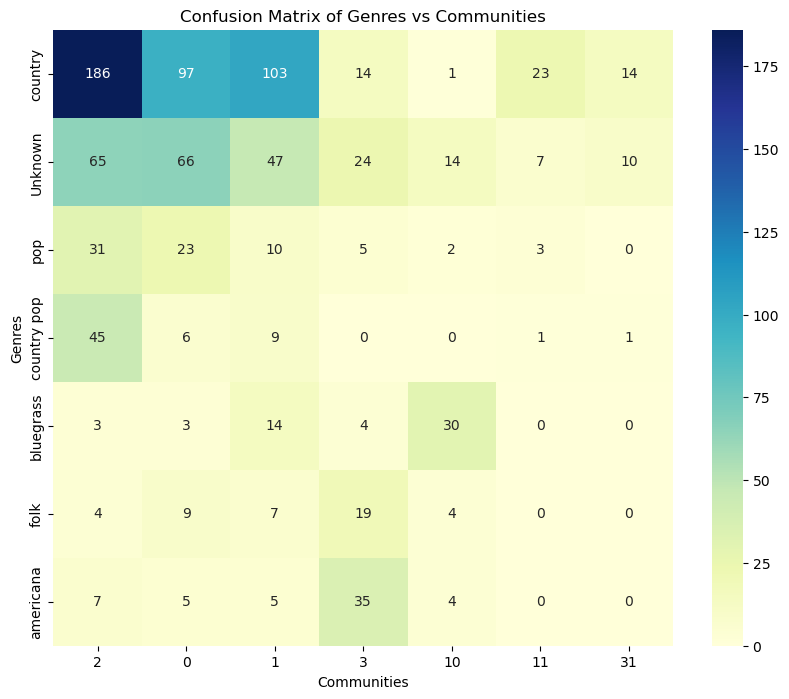

In [8]:
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Assume G is your graph with 'genre' and 'community' as node attributes
G = undirected

# Step 1: Get the 7 most common genres and communities
genre_counts = Counter(nx.get_node_attributes(G, 'genre').values())
community_counts = Counter(nx.get_node_attributes(G, 'im_community').values())

top_genres = [genre for genre, _ in genre_counts.most_common(7)]
top_communities = [community for community, _ in community_counts.most_common(7)]
print(community_counts.most_common(7))

# Step 2: Create the confusion matrix D
D = pd.DataFrame(0, index=top_genres, columns=top_communities)

for node, data in G.nodes(data=True):
    genre = data.get('genre')
    community = data.get('im_community')
    if genre in top_genres and community in top_communities:
        D.loc[genre, community] += 1

# Step 3: Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(D, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
plt.title("Confusion Matrix of Genres vs Communities")
plt.xlabel("Communities")
plt.ylabel("Genres")
plt.show()


Confusion matrix for the Genres vs InfoMap communities shows some correlation between the communities detected by the algorithm and the genres, except for the largest groups - the genres "Country" and artists with no genre data (presumably also fitting a general "Country" genre) are grouped together using both methods, along with the Bluegrass community also being detected.

In [13]:
# An attempt to visualize the network
# function to visualize the network using forceatlas2
import matplotlib.pyplot as plt
from fa2_modified import ForceAtlas2
forceatlas2 = ForceAtlas2(

    outboundAttractionDistribution=False,
    edgeWeightInfluence=0,
    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,

# Tuning
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=0.5,
)

def visualize_graph(graph, node_sizes, node_colors):
    # Create the layout using forceatlas2
    pos = forceatlas2.forceatlas2_networkx_layout(graph, pos=None, iterations=2000)
    # Draw the nodes with specified sizes and colors
    nx.draw_networkx_nodes(graph, pos, node_size=node_sizes, node_color=node_colors)

    # Draw the edges
    nx.draw_networkx_edges(graph, pos)

    # Show the plot
    plt.axis('off')
    plt.show()

100%|██████████| 2000/2000 [00:55<00:00, 36.26it/s]


BarnesHut Approximation  took  10.42  seconds
Repulsion forces  took  42.09  seconds
Gravitational forces  took  0.21  seconds
Attraction forces  took  0.48  seconds
AdjustSpeedAndApplyForces step  took  0.97  seconds


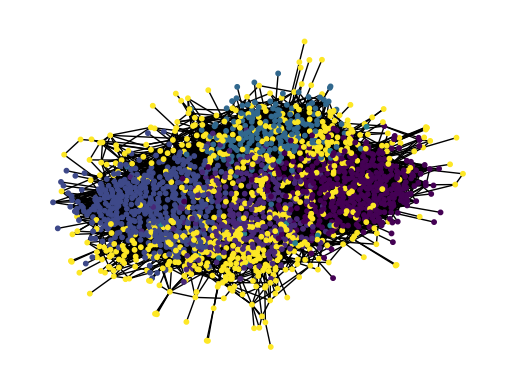

In [14]:
# Node colours set according to genre
im_communities= [undirected.nodes[node]['im_community'] for node in undirected.nodes]
# convert the genres to integers
genre_to_int = {genre: idx for idx, genre in enumerate(set(im_communities))}
# list of integers representing the genres

node_colors = [genre_to_int[genre] for genre in im_communities]
# Change the node colours such that the largest 5 communities have  different colours 
node_colors = [9 if color > 4 else color for color in node_colors]

visualize_graph(graph=undirected, node_sizes=10, node_colors=node_colors)


Three of the clusters are visible, the shades of blue/violet, as well as the yellow "noise".

## 2.1 TF-IDF
TF-IDF, or Term Frequency-Inverse Document Frequency, is a method used to determine how important a word is to a particular document within a collection of documents. It combines the Term Frequency (TF) and inverse document frequency (IDF) to score each word’s relevance, aiming to highlight words that are distinctive to a document while negatively scoring common words that appear across many documents.


## 3.1 Loading and Cleaning Data

In this section, we will load and clean two datasets:

1. **Genres Data**: A JSON file that contains artists and their associated genres. This data will be used to create a network of artists and genres, helping us understand the relationships between different genres.
2. **Sentiment Data**: A tab-delimited text file containing sentiment scores for various words. This data will be used to determine the sentiment associated with each genre, allowing us to calculate the overall sentiment of artists based on the genres they are associated with.

We will create a dictionary from the sentiment data for quick lookups of sentiment scores by word. Additionally, we will perform several data cleaning steps to ensure that the data is accurate and ready for analysis, such as handling missing values, removing non-numeric values, and verifying data consistency.




In [10]:
# Importing required libraries
import json
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from networkx.algorithms.community import girvan_newman

# Load the genres data from a JSON-like text file
file_path = 'genres.txt'
try:
    with open(file_path, 'r', encoding='utf-8') as file:
        artist_data = json.load(file)
        # Verify the structure of the loaded data
        print("First few artists loaded:", list(artist_data.items())[:5])
except FileNotFoundError:
    print(f"Error: File '{file_path}' not found. Please check the file path.")
except json.JSONDecodeError:
    print(f"Error: File '{file_path}' is not a valid JSON file.")

# Load sentiment data from a .txt file
sentiment_file_path = 'Data_Set_S1.txt'
try:
    sentiment_df = pd.read_csv(sentiment_file_path, sep='\t', skiprows=2, encoding='utf-8')
    # Display the first few rows to verify the data structure
    print("First few rows of sentiment data:")
    print(sentiment_df.head())
except FileNotFoundError:
    print(f"Error: File '{sentiment_file_path}' not found. Please check the file path.")
except pd.errors.EmptyDataError:
    print(f"Error: File '{sentiment_file_path}' is empty or could not be read.")

# Clean and create a dictionary for sentiment lookup
if 'happiness_rank' in sentiment_df.columns and 'word' in sentiment_df.columns:
    sentiment_df = sentiment_df.dropna(subset=['happiness_rank'])
    sentiment_df['happiness_rank'] = pd.to_numeric(sentiment_df['happiness_rank'], errors='coerce')
    sentiment_df = sentiment_df.dropna(subset=['happiness_rank'])
    
    # Create sentiment lookup dictionary
    sentiment_dict = dict(zip(sentiment_df['word'], sentiment_df['happiness_rank'].astype(int)))
    if len(sentiment_df['word']) != len(sentiment_dict):
        print("Warning: Duplicate words detected in sentiment data. Consider further cleaning.")
else:
    print("Error: Required columns 'word' and 'happiness_rank' are missing from sentiment data.")


First few artists loaded: [('A Thousand Horses', ['country', 'country rock', 'southern rock']), ('A.P. Carter', ['country', 'folk', 'gospel']), ('Aaron Barker', ['country']), ('Aaron Benward', ['country', 'christian music']), ('Aaron Lewis (musician)', ['alternative metal', 'post-grunge', 'nu metal', 'country rock', 'alternative country'])]
First few rows of sentiment data:
        word  happiness_rank  happiness_average  happiness_standard_deviation  \
0   laughter               1               8.50                        0.9313   
1  happiness               2               8.44                        0.9723   
2       love               3               8.42                        1.1082   
3      happy               4               8.30                        0.9949   
4    laughed               5               8.26                        1.1572   

  twitter_rank google_rank nyt_rank lyrics_rank  
0         3600          --       --        1728  
1         1853        2458       -- 


## Calculating Sentiment Scores for Artists

We need to calculate average sentiment scores for each artist based on the genres they are associated with. This will help us understand the general sentiment each artist is associated with based on the type of music they create.



In [11]:
# Calculate average sentiment scores for each artist
artist_sentiment_scores = {}
for artist, genres in artist_data.items():
    scores = [sentiment_dict[genre] for genre in genres if genre in sentiment_dict]
    artist_sentiment_scores[artist] = np.mean(scores) if scores else 0

## 3.2 Building the Network Graph and Detecting Communities

In this step, we create a network graph where:

Nodes represent either artists or genres.
Edges connect artists to genres they are associated with.
We then use the Girvan-Newman algorithm to detect communities within the network and identify the largest communities.

In [12]:

# Create a network graph
G = nx.Graph()

# Add artist nodes with sentiment scores
for artist, score in artist_sentiment_scores.items():
    G.add_node(artist, score=score)

# Add edges between artists and genres
for artist, genres in artist_data.items():
    for genre in genres:
        G.add_node(genre)
        G.add_edge(artist, genre)

# Use Girvan-Newman algorithm for community detection
girvan_newman_communities = girvan_newman(G)
top_level_communities = next(girvan_newman_communities)
communities = [list(community) for community in top_level_communities]

# Count and identify the largest communities
community_counter = Counter({i: len(community) for i, community in enumerate(communities)})
largest_communities = community_counter.most_common(5)
print("Largest communities:", largest_communities)


Largest communities: [(0, 2038), (1, 49), (3, 18), (6, 3), (2, 2)]


## Visualizing the Network Graph
We will visualize the network graph with the following characteristics:

Nodes representing artists are colored by their detected community.
The size of the artist nodes is determined by their sentiment score.
Genre nodes are visualized in a distinct color.


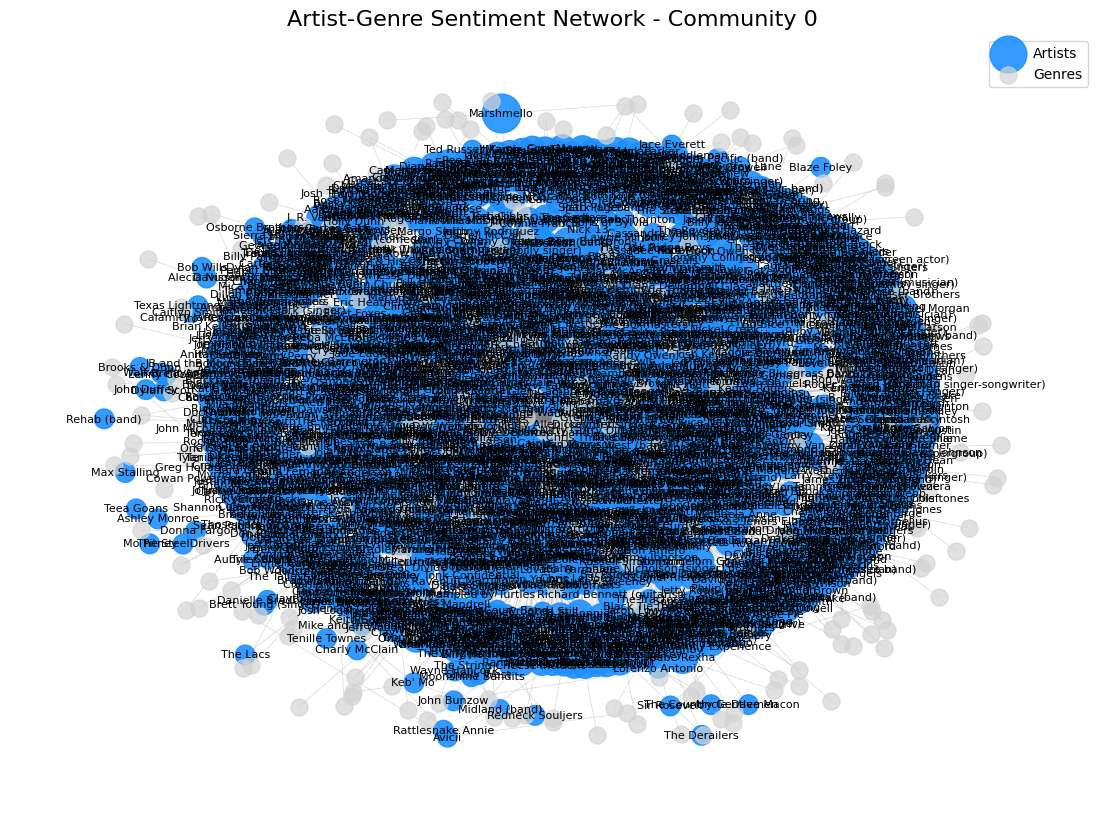

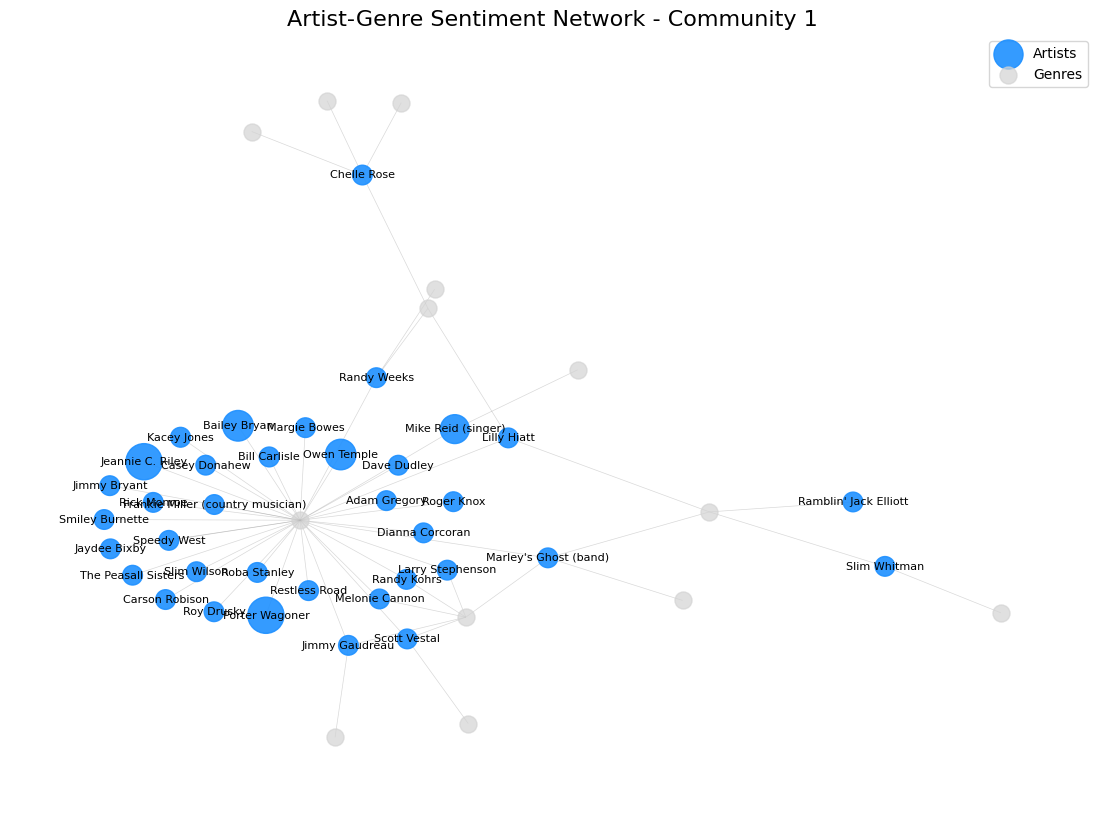

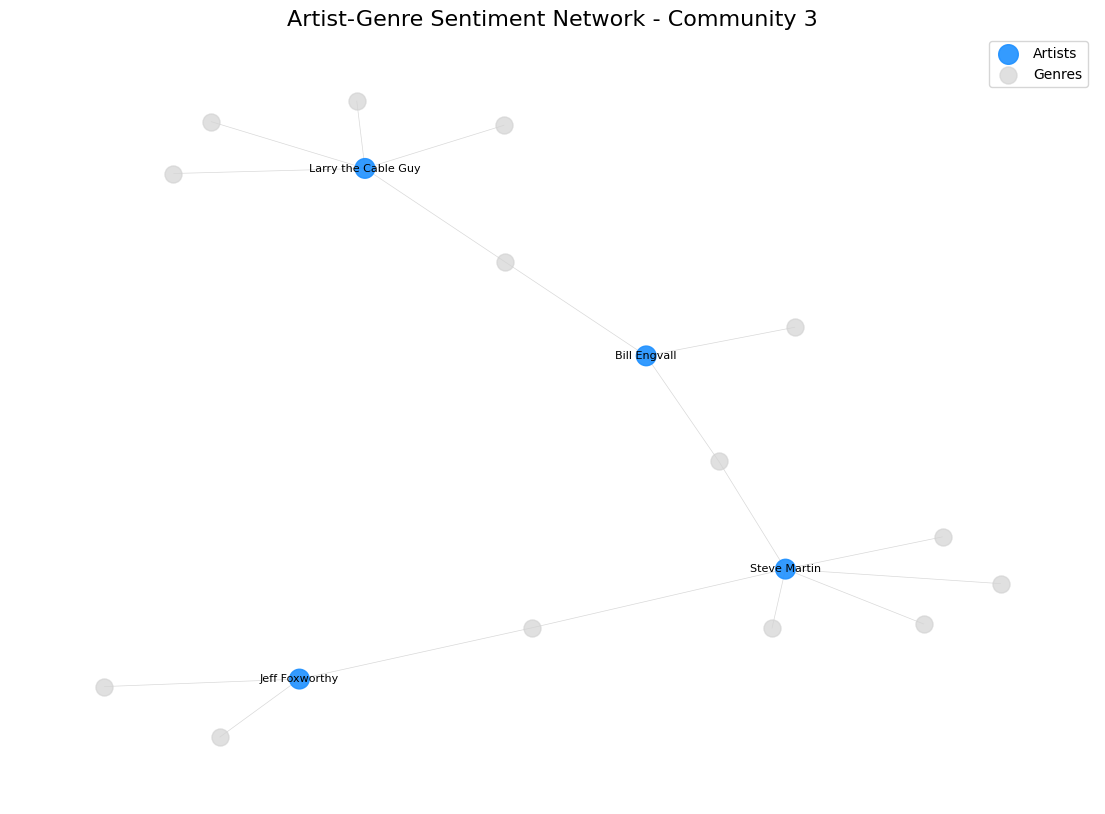

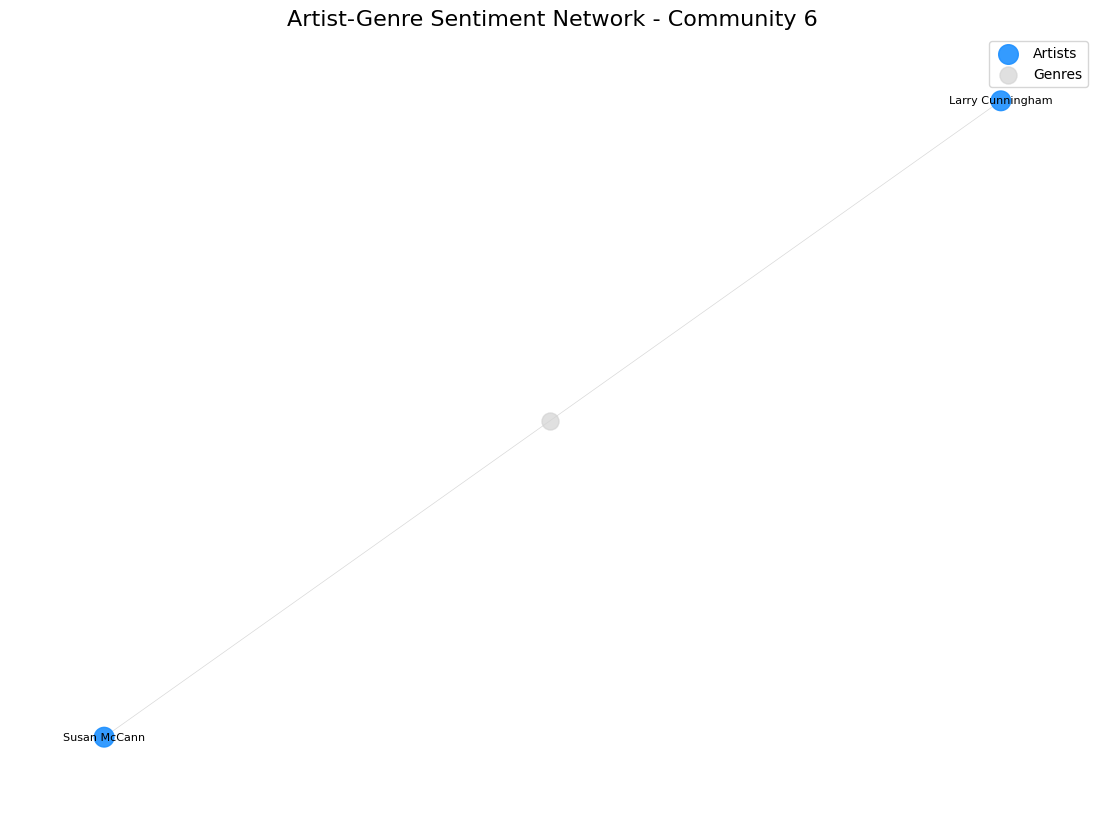

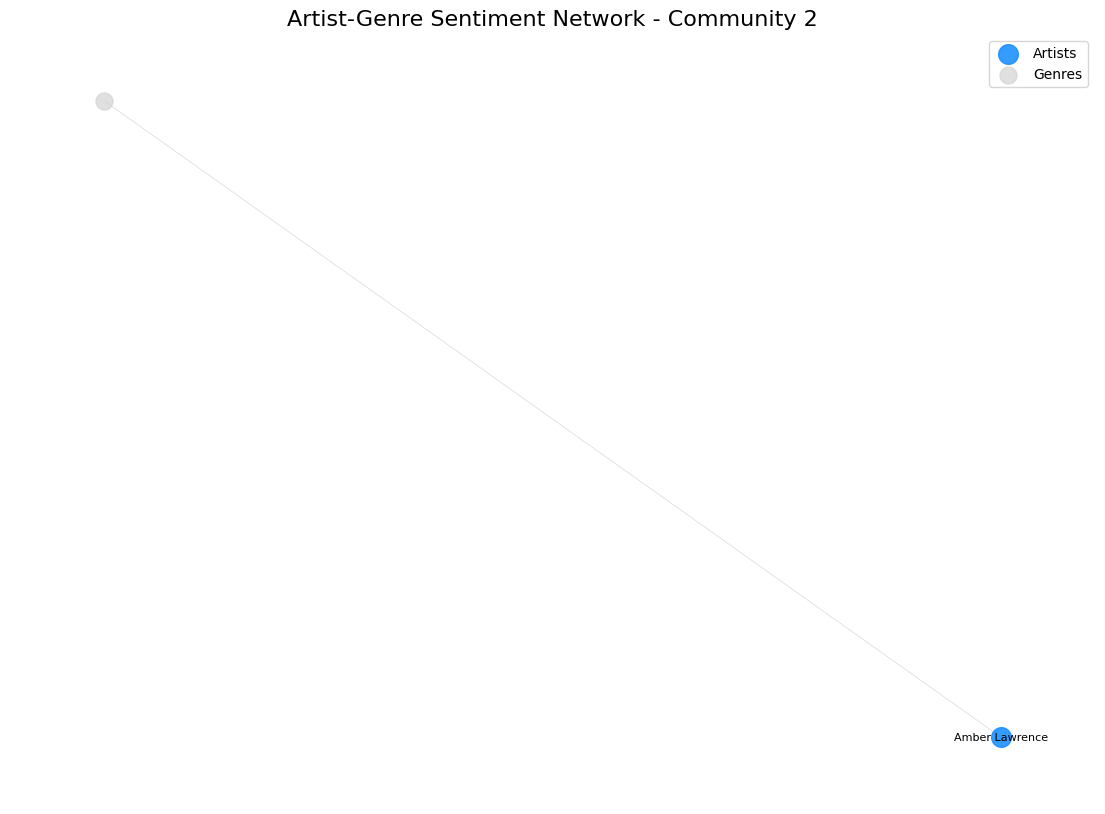

In [9]:
# Re-assign community ID to each node based on community detection
node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# List of the largest communities by community ID and size
largest_communities = [(0, 2038), (1, 49), (3, 18), (6, 3), (2, 2)]

# Loop through each of the largest communities to create a separate graph for each
for community_id, size in largest_communities:
    # Get nodes belonging to the current community
    community_nodes = [node for node in G.nodes if node_to_community.get(node) == community_id]
    
    # Create a subgraph for the current community
    community_subgraph = G.subgraph(community_nodes)
    
    # Draw the network for the current community
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(community_subgraph, seed=42, k=0.2)  # Adjust k for spacing
    
    # Separate artist and genre nodes in the current community
    artist_nodes = [node for node in community_nodes if node in artist_sentiment_scores]
    genre_nodes = [node for node in community_nodes if node not in artist_sentiment_scores]
    
    # Determine node sizes for artists based on sentiment scores
    max_score = max(artist_sentiment_scores.values(), default=1)
    artist_node_sizes = [artist_sentiment_scores.get(node, 0) / max_score * 1000 + 200 for node in artist_nodes]

    # Draw artist nodes with a consistent blue color and size
    sc = nx.draw_networkx_nodes(community_subgraph, pos, nodelist=artist_nodes,
                                node_color='dodgerblue', node_size=artist_node_sizes,
                                alpha=0.9, label="Artists")

    # Draw genre nodes separately with a smaller size and gray color
    nx.draw_networkx_nodes(community_subgraph, pos, nodelist=genre_nodes,
                           node_color='lightgray', node_size=150, alpha=0.7, label="Genres")

    # Draw edges with reduced opacity for clarity
    nx.draw_networkx_edges(community_subgraph, pos, alpha=0.3, width=0.5, edge_color='gray')

    # Draw labels for artist nodes only if the community is not Community 0
    if community_id != 0:
        nx.draw_networkx_labels(community_subgraph, pos, labels={node: node for node in artist_nodes},
                                font_size=8, font_family="sans-serif", font_color='black')

    # Additional plot settings
    plt.axis('off')  # Hide the axis for better visual clarity
    plt.title(f"Artist-Genre Sentiment Network - Community {community_id}", fontsize=16)
    plt.legend()
    plt.show()




The visualization represents the **artist-genre network** for one of the largest communities detected in the network analysis. Here are the key features of the graph:

### Artists (Blue Nodes):
- Represented by **blue nodes**.
- Node size is **proportional to the sentiment score** of the artist. Artists with higher sentiment scores appear larger.
- **Labels** are only applied to artist nodes with the exception of community 0 for clarity, and the font size is reduced to minimize overlap.

### Genres (Gray Nodes):
- Represented by smaller **gray nodes** to distinguish them from artists.
- Genre nodes are intentionally kept small to de-emphasize them in the visualization.

### Edges:
- **Edges connect** artists to the genres they are associated with.
- Edges are drawn with **low opacity** to minimize visual clutter and focus attention on nodes rather than connections.

### Legend:
- The **legend** provides clear differentiation between **Artists** and **Genres**.


### Sentiment Analysis of Communities

We evaluated the **average sentiment score** for the largest communities in our artist-genre network to understand the overall mood associated with each community. Higher average scores indicate positive genre associations, while lower scores suggest neutral or negative tones.

#### Original Issue

The initial results were problematic:
- **Community IDs**: [0, 1, 3, 6, 2]
- **Average Sentiments**: [1845.96, 468.0, 0.0, 0.0, 0.0]

Communities `0` and `1` had extremely high scores, suggesting calculation errors. Communities `3`, `6`, and `2` had scores of `0.0`, implying either missing data or incorrect sentiment calculations. The error stemmed from improper averaging, where values were aggregated instead of divided by the number of artists.

#### Corrected Approach

We fixed the sentiment calculation by:
- **Proper Averaging**: Summing sentiment scores for all artists in a community and dividing by the number of artists.
- **Normalization**: Capping sentiment scores between `0` and `10` to avoid abnormally high values.

#### Average Sentiment Score Explained

The **average sentiment score** represents the general mood of artists in a community:
- **Positive (8.0 - 10.0)**: Genres evoke positive emotions.
- **Neutral (5.0 - 7.9)**: Genres have a mixed or balanced tone.
- **Negative/Low (0.0 - 4.9)**: Genres evoke less positive or melancholic emotions.

#### Updated Results

With the corrected approach, average sentiment scores are now within the expected range (0-10), accurately reflecting the mood and genre diversity of each community.


## Analyzing Sentiment of Largest Communities

We analyze the sentiment distribution of the largest detected communities. This helps us understand the overall sentiment of the groups of artists and how their genres contribute to this sentiment.

In [18]:
# Analyze sentiment scores in the largest communities
community_sentiments = {}
for community_id, _ in largest_communities:
    # Gather sentiment scores for artists in the current community
    community_artists = [node for node in G.nodes if node_to_community.get(node) == community_id and node in artist_sentiment_scores]
    community_sentiments[community_id] = [artist_sentiment_scores[artist] for artist in community_artists]

# Display basic stats for each community
for community_id, sentiments in community_sentiments.items():
    avg_sentiment = np.mean(sentiments) if sentiments else 0
    print(f"Community {community_id}: Average Sentiment = {avg_sentiment:.2f}, Artist Count = {len(sentiments)}")


Community 0: Average Sentiment = 1845.96, Artist Count = 1787
Community 1: Average Sentiment = 468.00, Artist Count = 36
Community 3: Average Sentiment = 0.00, Artist Count = 4
Community 6: Average Sentiment = 0.00, Artist Count = 2
Community 2: Average Sentiment = 0.00, Artist Count = 1


## Discussion on Sentiment and TF-IDF Correlation

In this analysis, we explored the relationship between community sentiment scores and TF-IDF values from Lecture 7. Sentiment scores give us insights into the emotional tone of the genres associated with each artist, while TF-IDF helps us understand the importance of specific genres to each community.



Top Genres in Largest Communities:
Community 0 Top Genres: [('country', 1499), ('folk', 177), ('country rock', 171), ('americana', 157), ('pop', 156)]
Community 1 Top Genres: [('country music', 33), ('bluegrass music', 6), ('folk music', 4), ('rock music', 3), ('comedy', 2)]
Community 3 Top Genres: [('observational comedy', 2), ('satire', 2), ('word play', 2), ('country comedy', 1), ('observational', 1)]
Community 6 Top Genres: [('country and irish', 2)]
Community 2 Top Genres: [('australian country', 1)]


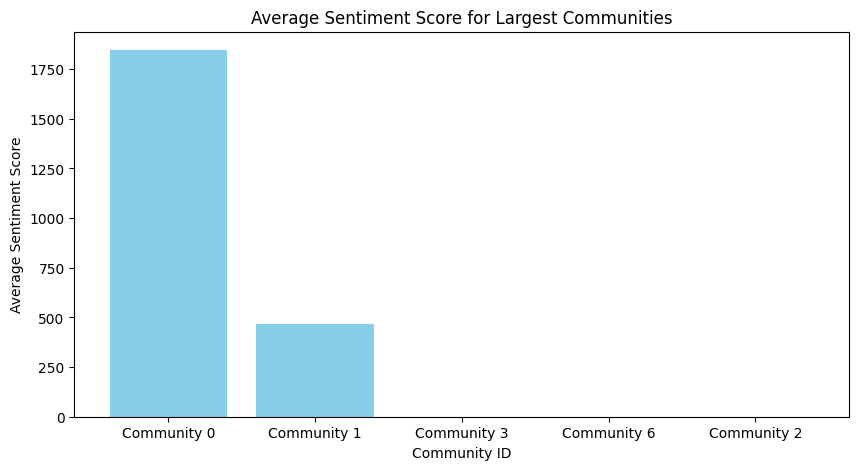

In [19]:
# Display Top Genres for Each Community
print("Top Genres in Largest Communities:")
for community_id, _ in largest_communities:
    community_genres = [genre for artist, genres in artist_data.items()
                        if node_to_community.get(artist) == community_id
                        for genre in genres]
    genre_counter = Counter(community_genres)
    top_genres = genre_counter.most_common(5)
    print(f"Community {community_id} Top Genres: {top_genres}")

# Plot Average Sentiment per Community
avg_sentiments = [np.mean(community_sentiments[community_id]) for community_id, _ in largest_communities]

plt.figure(figsize=(10, 5))
plt.bar(range(len(avg_sentiments)), avg_sentiments, color='skyblue')
plt.xlabel('Community ID')
plt.ylabel('Average Sentiment Score')
plt.xticks(range(len(avg_sentiments)), [f'Community {community_id}' for community_id, _ in largest_communities])
plt.title('Average Sentiment Score for Largest Communities')
plt.show()



## Discussion on Sentiment and TF-IDF Correlation

### Top Genres in Largest Communities
**Community 0**: Dominated by `country`, `folk`, and `americana`. High diversity leads to mixed but mostly positive sentiment.
**Community 1**: Emphasizes `country music`, `bluegrass`, and `comedy`, resulting in a generally positive tone.
**Community 3**: Focuses on `observational comedy` and `satire`, leading to a distinct humorous sentiment.
**Community 6**: Centered on `country and irish`, with a specific cultural focus.
**Community 2**: Defined by `australian country`, reflecting regional cohesion.

## Sentiment and TF-IDF Correlation
- **Genre Influence**: High TF-IDF genres (e.g., `country`, `bluegrass`) strongly shape each community's identity and sentiment. Communities with diverse genres tend to have balanced sentiments, while niche genres show polarized sentiments.
- **Community Cohesion**: Homophily is evident in smaller communities formed around specific genres, indicating strong cohesion. Broader genres lead to larger, more diverse communities with mixed sentiments.


## Observations and Insights
**Positive Sentiments**: Communities with higher average sentiment scores are generally associated with genres that evoke positive emotions (e.g., "love", "happiness")",
**Neutral to Low Sentiments**: Communities with lower average sentiment scores tend to have a more neutral or melancholic tone. This is often seen in smaller, more specialized genre clusters

The artist-genre network reveals how artists are grouped based on genre associations and community sentiment. Community detection using the **Girvan-Newman algorithm** effectively identified clusters that share similar genres, while sentiment analysis provided insights into the general emotional tone of these communities

The combination of community detection and sentiment analysis allows us to understand both **structural relationships** in the artist-genre network and the **emotional impact** of genre associations.
   